<a href="https://colab.research.google.com/github/JainAnki/ADSMI-Notebooks/blob/main/SentimentClassification_LinearClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Intelligence
## A program by IIT Madras and TalentSprint
### Module 2 Mini Project: Sentiment Analysis using linear classifiers and unsupervised clustering.

## Learning Objectives

At the end of the mini project, you will be able to -

* use a real world dataset.
* undertake several important steps like cleaning the data and normalizing the data points.
* do sentiment classification.
* compare between different types of classification methods and their pros and cons. 
* compare between supervised and unsupervised (clustering) techniques. 

### Goal of the project
The goal of this project is to train linear classification models that can recognize the sentiment of the reviewer. In this project we will be dealing with only positive and negative sentiments (binary classification).

**Disclaimer**: 
There are multiple ways to solve this problem, as there is no unique formula to solve.
This is just one such approach.

**Packages used:**  
* `Pandas` for data frames and easy to read csv files  
* `Numpy` for array and matrix mathematics functions  
* `Matplotlib` and `Seaborn` for visualization
*  `sklearn` for the metrics and pre-processing
* `scipy` for helper functions required at various stages of the project.
* `warnings` is used to supress warnings from different libraries used in the project.

### Importing the packages

In [ ]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy
import math
import random

# Importing linear classification algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis       
from sklearn.tree import DecisionTreeClassifier       
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

# Importing the clustering algorithms
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Importing preprocessing functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Importing metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

### Downloading a dataset containing amazon review information along with ratings

In [ ]:
#@title Download Dataset
!wget https://cdn.iisc.talentsprint.com/ADSMI/Datasets/amazon_reviews.zip
!unzip "amazon_reviews.zip"

--2022-09-19 04:07:14--  https://cdn.iisc.talentsprint.com/ADSMI/Datasets/amazon_reviews.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29949034 (29M) [application/zip]
Saving to: ‘amazon_reviews.zip’

amazon_reviews.zip  100%[===================>]  28.56M  6.28MB/s    in 4.5s    

2022-09-19 04:07:20 (6.28 MB/s) - ‘amazon_reviews.zip’ saved [29949034/29949034]

Archive:  amazon_reviews.zip
  inflating: amazon_reviews.csv      


## How does the dataset look like?
Lets use a standard dataset from Amazon which contains reviews and ratings from the customer. The original dataset has three features: name(name of the products), review(Customer reviews of the products), and rating(rating of the customer of a product ranging from 1 to 5). The review column will be the input column and the rating column will be used to understand the sentiments of the review. Here are some important data preprocessing steps:
The dataset has about 183,500 rows of data. There are 1147 null values which will be removed.
As the dataset is pretty big, it takes a lot of time to run some machine learning algorithms. We will use 30% of the data in this project which is still 54,000+ data points! The sample will be representative of the whole dataset.
If the rating is 1 and 2 that will be considered a negative review. And if the review is 3, 4, and 5, the review will be considered as a  positive review. We add a new column named ‘sentiments’ to the dataset that will use 1 for the positive reviews and 0 for the negative reviews. We read and display the contents of the dataset down below.

In [ ]:
#Read the dataset from the downloaded csv file
df = pd.read_csv('amazon_reviews.csv')

#getting rid of null values
df = df.dropna()

#Taking a 90% representative sample
np.random.seed(34)
df1 = df.sample(frac = 0.3)

#Adding the sentiments column
df1['sentiments'] = df1.rating.apply(lambda x: 0 if x in [1, 2] else 1)

print ("First five rows of the dataset")
df1.head(5)

First five rows of the dataset


,name,review,rating,sentiments
165191,"aden + anais Rayon From Bamboo Crib Sheet, Azu...",An off-white or cream sheet that is so soft. I...,5,1
108775,Hand Held Scalp Head Massager - Set of Three (...,I was skeptical about how well these will work...,5,1
162820,"Clevamama ClevaFoam Baby Pillow, Cream",It soft and material appears to be excellent. ...,5,1
148217,"Kids Line Velour Changing Pad Cover, Pirate Party",This is a very nice cover. I have two because ...,5,1
46428,"Angel Dear Blankie, Green Frog","I love these Lovies. They are cute, soft and d...",5,1


### Shape of the data

In [ ]:
print ("Shape of the data: ", df1.shape)

Shape of the data:  (54715, 4)


### Defining the input and expected output from our model.

Before starting the sentiment analysis, it is necessary to define the input features and the labels. Here there is only one feature, which is the ‘review’. The label will be the ‘sentiments’. The goal of this project is to train a model that can output if a review is positive or negative. Therefore, we store the data using two variables named `X` and `y`.

In [ ]:
# X is the input to the sentiment classifier
X = df1['review']

# y is the ground-truth/expected output to the sentiment classifier
y = df1['sentiments']

### Preprocessing the data
As we can see the data is present in the form of text. We cannot feed them directly to a machine learning algorithm which deals with real numbers. Thus, we first preprocess and vectorize the whole data. We use a TFIDF based vectorizer to vectorize the data. We also split the data into train and test splits using a `sklearn` function. The train and test splits (90% train and 10% test) will be kept the same throughout this project and to maintain parity and comparability between the algorithms.

In [ ]:
# Splitting the data into train and test splits
# We keep 90% for training and 10% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=24)

# Defining the TFIDF vectorizer
vectorizer = TfidfVectorizer()

# Generating the vectorized output for each sentences in train and test sets.
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print ("The shape of train inputs: ", X_train_vec.shape)
print ("The shape of test inputs: ", X_test_vec.shape)

The shape of train inputs:  (49243, 35520)
The shape of test inputs:  (5472, 35520)


We have the data preprocessed at this stage. We can now dive into the next level of algorithms for linear classification.

### Metrics to be used to measure the performance

We will use two metrics to measure performance of each algorithm.

1. Accuracy.
2. F1 Score.

Both of these are imported from the `sklearn` library.

### K-Nearest Neighbour Classifier
As already covered in the assignments, K-NN is a non-parametric algorithm, which means it does not make any assumption on underlying data. It is also called a lazy learner algorithm because it does not learn from the training set immediately instead it stores the dataset and at the time of classification, it checks the relative distance of any test data point with all points in the train set to make a decision.



In [ ]:
# Define the KNN classifier
# Number of neighbours is 5
knn = KNeighborsClassifier(n_neighbors=5)

# Training the KNN classifier
knn.fit(X_train_vec, y_train)

# Calculating accuracy on the KNN classifier
# The accuracy is within 0 and 1 in this snippet
knn_score = knn.score(X_test_vec, y_test)
print("Accuracy of the sentiment classification using the KNN classifier: ", knn_score)

# Predicting on the test set
y_pred = knn.predict(X_test_vec)

# F1 score calculation
knn_f1_score = f1_score(y_pred, y_test)

print ("F1 Score for sentiment classification using the KNN classifier: ", knn_f1_score)

Accuracy of the sentiment classification using the KNN classifier:  0.8634868421052632
F1 Score for sentiment classification using the KNN classifier:  0.924811273276296


Please change the parameter `n_neighbors` to different values to check its effect on the accuracy! 

### Logistic Regression

Once we have tested out the KNN classifier, we now move on to other algorithms which can be used for classification. The next algorithm which we will check is the logistic regression algorithm. 

The logistic function, more popularly called the sigmoid function was to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment. 

It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

$\frac{1}{ (1 + e^{-value})}$

Where $e$ is the base of the natural logarithms and value is the actual numerical value that you want to transform. Below is a plot of the numbers between $-5$ and $5$ transformed into the range $0$ and $1$ using the logistic function.

Therefore, we now use the logistic regression algorithm to classify our dataset into positive and negative sentiments.

In [ ]:
# Logistic regression model is defined
logistic_regression = LogisticRegression()

# Training the logistic regression classifier
logistic_regression.fit(X_train_vec, y_train)

# Calculating accuracy on the logistic regression classifier
# The accuracy is within 0 and 1 in this snippet
lr_score = logistic_regression.score(X_test_vec, y_test)
print("Accuracy of the sentiment classification using the Logistic Regression based classifier: ", lr_score)

# Predicting on the test set
y_pred_lr = logistic_regression.predict(X_test_vec)

# F1 score calculation
lr_f1_score = f1_score(y_pred_lr, y_test)

print ("F1 Score for sentiment classification using the Logistic Regression based classifier: ", lr_f1_score)

Accuracy of the sentiment classification using the Logistic Regression based classifier:  0.908625730994152
F1 Score for sentiment classification using the Logistic Regression based classifier:  0.94824016563147


As we see, logistic regression gives a $4\%$ accuracy increase compared to a KNN based classifier. Similarly the F1 score also improved by $2\%$ compared to the KNN classifier's results.

### Support Vector Machines and Dimensionality Reduction using PCA

The next classifier we look into are support vector machines. 

![wget](https://cdn.talentsprint.com/aiml/aiml_2020_b14_hyd/experiment_details_backup/linear_data.png)

While the other classifiers such as the perceptron and the logistic regression uses a similar concept of finding a boundary between two classes using a straight line, SVMs aim to maximize this boundary. Therefore, not only the SVM tries to find a boundary, it tries to find the best boundary that separates the two classes. Again, with very simple tricks the two class classification can be easily extended to a multiclass classification. The formal formulation of a SVM is,

$g(x) = w^Tx + b$, is the equation of the line we want to find with weights $w$ and a bias $b$.

Now as seen from the figure, $g(x) = k$ and $g(x) = -k$ will give two worst lines for classification as they are right at the boundary of one of the classes. We need to maximize the distance of the line from both of the classes.

Therefore,

Maximize $k$ such that :

$-w^Tx + b \geq k \: for \: d_i == 1$

$-w^Tx + b \leq k \: for \: d_i == -1$

We keep $g(x) \geq 1$ and minimize $||w||$.

We finally write the final minimization function (uses Lagrangians to come to this solution).

Minimize: $J(w, b, \alpha) = \frac{1}{2}w^Tw - \Sigma_{i=1}^{N}(\alpha_id_i(w^Tx_i + b)) + \Sigma_{i=1}^{N}(\alpha_i)$

There are multiple types of SVM. We first use the standard linear SVM and check the performance of the model. However, SVM cannot be directly used on this dataset. 

#### Reducing the number of feature dimensions in the input data



The data is too large and the normal SVM function from `sklearn` will take a lot of time to run. Therefore, we first apply a PCA based dimensionality reduction technique on the input data. This will be followed by different types of SVM techniques and the performance can be compared. Since, dimensionality reduction is applied, a slight drop in performance is expected. However, with the improvement in the time taken for training a SVM in mind, it is important we first apply PCA based dimensionality reduction.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [ ]:
# Defining the PCA model
# We use the truncated SVD function because our TFIDF vectorizer has generated a sparse input matrix
pca = TruncatedSVD(20)

# Fitting the training data
pca.fit(X_train_vec)

# Reducing the dimensions of the training data
X_train_vec_dim_reduced = pca.transform(X_train_vec)

# Reducing the dimensions of the testing data
X_test_vec_dim_reduced = pca.transform(X_test_vec)

Please change the number of components (set at $20$ currently!) and see the effect it has on the performance.

#### Hard margin SVM classifier

Now that we have reduced the dimension of the data, we can train and evaluate the performance of the SVM classifier. Please note that the following SVM is a hard margin SVM classifier. 

In [ ]:
# Linear SVM is defined.
svm_classifier = svm.SVC(kernel='linear', random_state=0, gamma='auto')

# Training the SVM classifier
svm_classifier.fit(X_train_vec_dim_reduced, y_train)

# Calculating accuracy on the SVM classifier
# The accuracy is within 0 and 1 in this snippet
svm_score = svm_classifier.score(X_test_vec_dim_reduced, y_test)
print("Accuracy of the sentiment classification using linear SVM: ", svm_score)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test_vec_dim_reduced)

# F1 score calculation
f1_svm_score = f1_score(y_pred_svm, y_test)

print ("F1 Score for sentiment classification using linear SVM: ", f1_svm_score)

Accuracy of the sentiment classification using linear SVM:  0.8536184210526315
F1 Score for sentiment classification using linear SVM:  0.9210292812777285


#### Soft margin SVM classifier

We now train a soft margin SVM classifier. The soft margin SVM allows for some level of tolerence to mis-classifications during training to overfit less on the training data. Let us see its effect.

In [ ]:
# Linear SVM is defined.
svm_classifier_sm = svm.SVC(kernel='linear', random_state=0, C=10)

# Training the SVM classifier
svm_classifier_sm.fit(X_train_vec_dim_reduced, y_train)

# Calculating accuracy on the soft margin SVM classifier
# The accuracy is within 0 and 1 in this snippet
svm_score_sm = svm_classifier_sm.score(X_test_vec_dim_reduced, y_test)
print("Accuracy of the sentiment classification using soft margin SVM: ", svm_score_sm)

# Predicting on the test set
y_pred_svm_sm = svm_classifier_sm.predict(X_test_vec_dim_reduced)

# F1 score calculation
f1_svm_score_sm = f1_score(y_pred_svm_sm, y_test)

print ("F1 Score for sentiment classification using soft margin SVM: ", f1_svm_score_sm)

Accuracy of the sentiment classification using soft margin SVM:  0.8536184210526315
F1 Score for sentiment classification using soft margin SVM:  0.9210292812777285


Please check how accuracy and F score varies with $C$. Also note the run times. 

#### Kernel SVM
We will check the effect of using Kernel SVMs on the performance. Kernel functions project the data into higher dimensional space which allows the data to be separated linearly in that space. This is especially useful when the data in not linearly separable in the original input space.

In [ ]:
# Kernel SVM is defined.
svm_classifier_kernel = svm.SVC(kernel='rbf', random_state=0)

# Training the SVM classifier
svm_classifier_kernel.fit(X_train_vec_dim_reduced, y_train)

# Calculating accuracy on the kernel SVM classifier
# The accuracy is within 0 and 1 in this snippet
svm_score_kernel = svm_classifier_kernel.score(X_test_vec_dim_reduced, y_test)
print("Accuracy of the sentiment classification using kernel SVM: ", svm_score_kernel)

# Predicting on the test set
y_pred_svm_kernel = svm_classifier_kernel.predict(X_test_vec_dim_reduced)

# F1 score calculation
f1_svm_score_kernel = f1_score(y_pred_svm_kernel, y_test)
print ("F1 Score for sentiment classification using kernel SVM: ", f1_svm_score_kernel)

Accuracy of the sentiment classification using kernel SVM:  0.8536184210526315
F1 Score for sentiment classification using kernel SVM:  0.9210292812777285


### Naive Bayes

These classifiers are built on the Bayes rule. We try to find the probability of a label given the observations made, which we can write as $P(L~|~{D})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm D}) = \frac{P({\rm D}~|~L)P(L)}{P({\rm D})}
$$

If we have two classes (two labels), let them be denoted by $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm D})}{P(L_2~|~{\rm D})} = \frac{P({\rm D}~|~L_1)}{P({\rm D}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm D}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through a "Naive" assumption that each label is associated with a speicfic distribution (often a gaussian).

In [ ]:
# Defining the naive bayes model. In this we assume the distribution associated with a label is a gaussian one.
nb = GaussianNB()

# Training the model on the train split
nb.fit(X_train_vec_dim_reduced, y_train);

# Calculating accuracy on the naive bayes classifier
# The accuracy is within 0 and 1 in this snippet
score_nb = nb.score(X_test_vec_dim_reduced, y_test)
print("Accuracy of the sentiment classification using Naive Bayes: ", score_nb)

# Predicting on the test set
y_pred_nb = nb.predict(X_test_vec_dim_reduced)

# F1 score calculation
f1_nb_score = f1_score(y_pred_nb, y_test)

print ("F1 Score for sentiment classification using Naive Bayes: ", f1_nb_score)

Accuracy of the sentiment classification using Naive Bayes:  0.8137792397660819
F1 Score for sentiment classification using Naive Bayes:  0.889682797445058


### Decision Trees



Till now we have seen KNN, logistic regression, different types of SVM classifiers. Let us now check out a different type of a classifier called the Decision Trees. Decision Trees are supervised Machine Learning algorithms that can perform both classification and regression tasks and even multioutput tasks. They can handle complex datasets. As the name shows, it uses a tree-like model to make decisions in order to classify or predict according to the problem. It is an ML algorithm that progressively divides datasets into smaller data groups based on a descriptive feature until it reaches sets that are small enough to be described by some label.

The most important part of a decision tree is its explainability!

The importance of decision tree algorithm is that it has many applications in the real world. For example:

1. In the Healthcare sector: To develop Clinical Decision Analysis tools which allow decision-makers to apply for evidence-based medicine and make objective clinical decisions when faced with complex situations.
2. Virtual Assistants (Chatbots): To develop chatbots that provide information and assistance to customers in any required domain.
3. Retail and Marketing: Sentiment analysis detects the pulse of customer feedback and emotions and allows organizations to learn about customer choices and drives decisions.

In [ ]:
# Create DT classifier with max_depth = 5
dt = DecisionTreeClassifier(max_depth = 5, random_state=1234)

# Fit the DT with the training data
dt.fit(X_train_vec, y_train)

# Calculating accuracy on the decision tree classifier
# The accuracy is within 0 and 1 in this snippet
score_dt = dt.score(X_test_vec, y_test)
print("Accuracy of the sentiment classification using Decision Trees: ", score_dt)

# Predicting on the test set
y_pred_dt = dt.predict(X_test_vec)

# F1 score calculation
f1_dt_score = f1_score(y_pred_dt, y_test)

print ("F1 Score for sentiment classification using Decision Trees: ", f1_dt_score)

Accuracy of the sentiment classification using Decision Trees:  0.8609283625730995
F1 Score for sentiment classification using Decision Trees:  0.9238466926848794


We can also check the result of the decision tree by printing it. Lets check that out too.

In [ ]:
# Generating text representation
text_representation = tree.export_text(dt)


# Displaying the result
print ("The decision tree generated is: \n")
print(text_representation)

The decision tree generated is: 

|--- feature_34317 <= 0.04
|   |--- feature_21050 <= 0.03
|   |   |--- feature_9708 <= 0.04
|   |   |   |--- feature_26144 <= 0.05
|   |   |   |   |--- feature_26147 <= 0.08
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_26147 >  0.08
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_26144 >  0.05
|   |   |   |   |--- feature_16821 <= 0.03
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_16821 >  0.03
|   |   |   |   |   |--- class: 1
|   |   |--- feature_9708 >  0.04
|   |   |   |--- feature_33843 <= 0.07
|   |   |   |   |--- feature_2414 <= 0.11
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2414 >  0.11
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_33843 >  0.07
|   |   |   |   |--- feature_31219 <= 0.08
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_31219 >  0.08
|   |   |   |   |   |--- class: 1
|   |--- feature_21050 >  0.03
|   |   |--- feature_18618 <= 0.02
|   

Please change the parameter `max_depth` and check its effect on the accuracy and F score for decision trees!

### Ensemble Learning
Till now we have been dealing with standalone models. However, what happens if we use multiple linear classifiers together? Therefore, instead of using a single predictor if we aggregate the predictions of a group of predictors (such as classifiers or regressors), we will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble, thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method. There are multiple types of ensemble methods that can be used. The most common method is voting.

Therefore, we take a look at this technique and check its performance for our task!

In this technique, we first define multiple classifiers (all of them used above). We then train all of them as well as the voting scheme to check the final result. Also, since the Naive Bayes and the SVMs take dimensionally reduced input (original dimensions will cause RAM overflow), we feed dimensionally reduced inputs to all the classifiers.

In [ ]:
# Define LogisticRegression, KNN, SVM, Naive Bayes and VotingClassifier
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=5)
nb_clf = GaussianNB()
svc_clf = svm.SVC(kernel='linear', random_state=0, gamma='auto', probability=True)

# Creating list of tuples having [(name1, classifier1),...]
classifiers = [('lr', log_clf), ('knn', knn_clf), ('svm', svc_clf), ('nb', nb_clf)]

# Defining the voting classifier
voting_clf = VotingClassifier(estimators= classifiers, voting='soft')

# Training all the classifiers one by one
# Printing the accuracy for each of them
for clf in (log_clf, knn_clf, svc_clf, nb_clf, voting_clf):
    clf.fit(X_train_vec_dim_reduced, y_train)
    y_pred = clf.predict(X_test_vec_dim_reduced)
    print(clf.__class__.__name__, " - Accuracy: ", accuracy_score(y_test, y_pred))

LogisticRegression  - Accuracy:  0.8556286549707602
KNeighborsClassifier  - Accuracy:  0.8382675438596491
SVC  - Accuracy:  0.8536184210526315
GaussianNB  - Accuracy:  0.8137792397660819
VotingClassifier  - Accuracy:  0.856359649122807


As we can see, the accuracy of the voting classifier (ensemble of all the classifiers) is the best among all and shows some improvement! Next, we check out random forests which uses multiple decision trees in an ensemble manner.

### Random Forests

A random forest is a collection of decision trees whose results are aggregated into one final result. Random Forest  is a supervised classification algorithm. There is a direct relationship between the number of trees in the forest and the results it can get: the larger the number of trees, the more accurate the result. But here creating the forest is not the same as constructing the decision tree with the information gain or gain index approach.
Steps:
1. Randomly select “k” features from total “m” features where k << m as shown in the figure below
2. Among the “k” features, calculate the node “d” using the best split point
3. Split the node into leaf nodes using the best split
4. Repeat the 1 to 3 steps until “l” number of nodes has been reached.
5. Build forest by repeating steps 1 to 4 for “n” number times to create “n” number of trees.
6. Take the test features and use the rules of each randomly created decision tree to predict the outcome and stores the predicted outcome (target)
7. Calculate the votes for each predicted target
8. Consider the high voted predicted target as the final prediction from the random forest algorithm

We use this method to check the performance of our task too.

In [ ]:
# Defining the random forest classifier 
rf = RandomForestClassifier(n_estimators=300, max_depth=5, max_leaf_nodes=32, random_state=12)

# Fitting the training data on the random forest classifier
rf.fit(X_train_vec, y_train)

# Predicting outputs on the test set
y_pred_rf = rf.predict(X_test_vec)

# Calculating scores
f1_rf_score = f1_score(y_pred_rf, y_test)
score_rf = accuracy_score(y_pred_rf, y_test)

# Printing accuracy and F1 score for the algorithm
print("Accuracy of the sentiment classification using Random Forests: ", score_rf)
print ("F1 score of the sentiment classification using Random Forests: ", f1_rf_score)

Accuracy of the sentiment classification using Random Forests:  0.8536184210526315
F1 score of the sentiment classification using Random Forests:  0.9210292812777285


The random forest function has multiple other attributes which can be tried out and the performance can be noted. The attributes will be available in https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Till now we have been using the labels to train all the algorithms on the training data. This comes under the paradigm of supervised learning. However, can this be done by a unsupervised manner. This means, we wont be providing labels while training certain algorithms and the algorithms are tasked to find the patterns present in the dataset by themselves. Let us delve into such clustering algorithms.

### Unsupervised Learning (Clustering in our case)

#### K-Means Clustering
The K-Means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
Each point is closer to its own cluster center than to other cluster centers.
These two assumptions are the basis of the k-means model.

We use the `MiniBatchKMeans` function from the `sklearn` library for this task. We don't use the normal K-Means functions to improve the speed of execution. 

Here the number of clusters is equal to 2 because we have 2 classes and we want the model to cluster the data into 2 clusters.



In [ ]:
# Defining the KMeans model
kmeans = MiniBatchKMeans(n_clusters=2)

# Training the model.
# Check how we don't use labels! :)
kmeans.fit(X_train_vec)

# A helper function to help labelling the test predictions
def label(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

# Assigning a label to each cluster
labelled_clusters = label(2, y_train, kmeans.labels_)

# Predicting outputs on the test set
test_labels = kmeans.predict(X_test_vec)

# Calculating scores
f1_kmeans_score = f1_score([ labelled_clusters[label] for label in test_labels], y_test)
score_kmeans = accuracy_score([ labelled_clusters[label] for label in test_labels], y_test)

# Printing accuracy and F1 score for the algorithm
print("Accuracy of the sentiment classification using KMeans: ", score_kmeans)
print ("F1 score of the sentiment classification using KMeans: ", f1_kmeans_score)

Accuracy of the sentiment classification using KMeans:  0.8536184210526315
F1 score of the sentiment classification using KMeans:  0.9210292812777285


We find that even with an unsupervised learning algorithm, we are able to get a good amount of accuracy on this dataset. Please note that, this will not be the case for most of the other algorithms, but seems to work fine on our dataset.

How to plot the K-Means clusters? Let us try out another cool stuff. We use PCA to make the data 2 dimensional and then apply K-Means and check what happens.

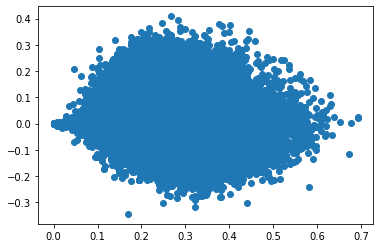

In [ ]:
# Defining the PCA model
# We use the truncated SVD function because our TFIDF vectorizer has generated a sparse input matrix
pca = TruncatedSVD(2)

# Fitting the training data
pca.fit(X_train_vec)

# Reducing the dimensions of the training data
X_train_vec_dim_reduced_2 = pca.transform(X_train_vec)

# Reducing the dimensions of the testing data
X_test_vec_dim_reduced_2 = pca.transform(X_test_vec)

plt.scatter(X_train_vec_dim_reduced_2[:, 0], X_train_vec_dim_reduced_2[:, 1])

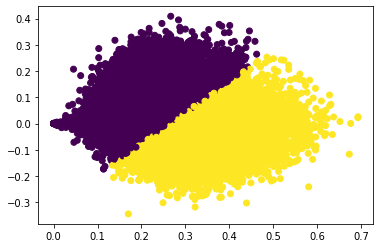

In [ ]:
# Defining the KMeans model
kmeans_2 = MiniBatchKMeans(n_clusters=2)

# Training the model.
# Check how we don't use labels! :)
kmeans_2.fit(X_train_vec_dim_reduced_2)

# Plotting the clusters
plt.scatter(X_train_vec_dim_reduced_2[:, 0], X_train_vec_dim_reduced_2[:, 1], c=kmeans_2.labels_);

#### Gaussian Mixture Models

We next check our results on another type of clustering which is very popular in the literature. The Gaussian Mixture Models. Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together. Gaussian Mixture Models are probabilistic models and use the soft clustering approach for distributing the points in different clusters. Therefore, for any given point we will check its probability of belonging to one of the $n$ gaussian distributions.

Accuracy of the sentiment classification using GMM:  0.48410087719298245
F1 score of the sentiment classification using GMM:  0.6093814860938148


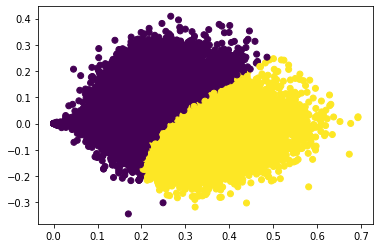

In [ ]:
# Defining the GMM
model_gmm = GaussianMixture(n_components=2, random_state=0)

# Fitting the training data
# X_train_vec_dim_reduced_2 has the training data
model_gmm.fit(X_train_vec_dim_reduced_2)

# Get the train and test set predictions
gmm_labels_train = model_gmm.predict(X_train_vec_dim_reduced_2)
gmm_labels = model_gmm.predict(X_test_vec_dim_reduced_2)

# Calculating scores
f1_gmm_score = f1_score(gmm_labels, y_test)
score_gmm = accuracy_score(gmm_labels, y_test)

# Printing accuracy and F1 score for the algorithm
print("Accuracy of the sentiment classification using GMM: ", score_gmm)
print ("F1 score of the sentiment classification using GMM: ", f1_gmm_score)

# Plotting the results
plt.scatter(X_train_vec_dim_reduced_2[:, 0], X_train_vec_dim_reduced_2[:, 1], c=gmm_labels_train);

## Visualizing some results

We have trained both supervised and unsupervised classification algorithms till now. Let us now check out some sentences and their corresponding predictions. We pick the predictions randomly from the logistic regression algorithm and show here. You can change variable names and check predictions from other algorithms.

In [ ]:
def label2text(label):
  if label == 1:
    return "POSITIVE EMOTION"
  else:
    return "NEGATIVE EMOTION"

def get_index(random_key, all_keys):
  for i, one_key in enumerate(all_keys):
    if one_key == random_key:
      return i

In [ ]:
# We already have stored the predictions (labels) previously.
# y_pred_lr has the predictions from logistic regression. 
# Try other y_pred_.. for outputs from other algorithms

# Select random index
random_key = random.choice(X_test.keys())

# Printing the sentence
print ("Sentence")
print ("----------------------------------------------")
print (X_test[random_key])
print ("----------------------------------------------")
print ("\n\n")

# Printing the ground-truth label
print ("Ground-truth Label")
print ("----------------------------------------------")
print (label2text(y_test[random_key]))
print ("----------------------------------------------")
print ("\n\n")


# Printing the predicted label
# You need to change this part of the code to get the rest of the classifier results
# Change y_pred_lr to other y_preds here
print ("Predicted Label")
print ("----------------------------------------------")

random_idx = get_index(random_key, X_test.keys())
print (label2text(y_pred_lr[random_idx]))
print ("----------------------------------------------")
print ("\n\n")

Sentence
----------------------------------------------
This product arrived as described and very quickly. It is exactly what I needed to design my dons playroom. The squares are a nice large size to cover the area. Found a better price in the stores however.
----------------------------------------------



Ground-truth Label
----------------------------------------------
POSITIVE EMOTION
----------------------------------------------



Predicted Label
----------------------------------------------
POSITIVE EMOTION
----------------------------------------------





## Input your own sentences and check results!

We can even enter and input our own sentences. Please keep the sentences to be imaginary reviews. Since the model has only seen amazon reviews, it will be otherwise harder to predict anything. The sentences must first be vectorized using the TFIDF vectorizer followed by passing through any of the trained models. Again, we only show results from the Logistic Regression network. Please remember that SVM and Naive Bayes uses PCA first to dimensionally reduce the data. This means that we need to do the same steps incase we want to get outputs from those models. 



In [ ]:
# Inputting the review into the code
# We use user input in the form of the library function called "input"
input_review = input("Enter your review in the text box and hit ENTER: ")

# Printing the review for reference
print ("Your review: ", input_review)

# Using TFIDF vectorizer for the text
X_test_user = vectorizer.transform([input_review])

# Predicting the output from the logistic regression system
user_pred_lr = logistic_regression.predict(X_test_user)

# Printing the result
print (label2text(user_pred_lr))






Enter your review in the text box and hit ENTER: Movie is awesome and interesting
Your review:  Movie is awesome and interesting
POSITIVE EMOTION


## Report the findings

Report the outputs you get from different reviews and in the different classifiers?